# Load Data

In [1]:
%load_ext autoreload
%autoreload 2
import os; import sys; sys.path.append('../')
import pandas as pd
import tqdm
import warnings
import copy
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import networkx as nx
import numpy as np
from collections import Counter
from collections import OrderedDict
import matplotlib.pyplot as plt
import csv

In [2]:
## Configure file and folder names
datafolder = "../data"
spadl_h5 = os.path.join(datafolder,"spadl-statsbomb.h5")

In [3]:
games = pd.read_hdf(spadl_h5,"games")
games = games[games.competition_name == "La Liga"]
print("nb of games:", len(games))

nb of games: 348


# Helper Functions

In [4]:
def players_in_pos(pos):
    contribution_action = ['pass', 'dribble', 'throw_in', 'corner_crossed', 'freekick_crossed', 'cross', 'shot', 
                  'freekick_short', 'goalkick', 'corner_short', 'shot_penalty']
    
    pos_players = []
    team = None
    
    for play in pos:
        player = play['player_name']
        if play['type_name'] in contribution_action and play['result_name'] == 'success':
            team = play['team_name']
            if player not in pos_players:
                pos_players.append(player)
    
    return pos_players, team

In [5]:
def change_possession(action, action_team, possession_team, result):
    end_pos = ['bad_touch', 'foul']
    change_team = ['pass', 'dribble', 'throw_in', 'corner_crossed', 'freekick_crossed', 'cross', 'shot', 
                  'freekick_short', 'goalkick', 'corner_short', 'shot_penalty', 'keeper_pick_up']
    success_change = ['tackle', 'interception', 'take_on', 'clearance', 'keeper_claim', 'keeper_save', 
                      'keeper_punch']
    
    if possession_team == None:
        if result == 'success':
            if action in change_team:
                possession_team = action_team
        else:
            return False, None
    
    
    if action in end_pos:
        return True, None
    
    if action_team != possession_team:
        if action in change_team:
            return True, action_team
        if result == 'success':
            if action in success_change:
                return True, action_team
            
    return False, possession_team

In [6]:
def extract_possessions(actions):
    all_possessions = []
    curr_possession = []
    team1 = []
    team2 = []
    
    
    possessing_team = actions.loc[0]["team_name"]
    team1_name = actions.loc[0]["team_name"]
    
    for i in range(len(actions)):
        # Extract possession
        action = actions.loc[i]["type_name"]
        action_team = actions.loc[i]["team_name"]
        
        if action_team != team1_name:
            team2_name = action_team
        
        result = actions.loc[i]["result_name"]
        end_pos, possessing_team = change_possession(action, action_team, possessing_team, result)
        
        if end_pos:
            all_possessions.append(copy.deepcopy(curr_possession))
            curr_possession = []

        curr_possession.append(actions.loc[i])
        
        # Identify players
        if (len(team1) == 14 and len(team2) == 14):
            continue
        
        player = actions.loc[i]["player_name"]
        if action_team == team1_name:
            if player not in team1:
                team1.append(player)
        else:
            if player not in team2:
                team2.append(player)

    return all_possessions, team1, team2, team1_name, team2_name

In [7]:
def pos_pass_list(pos):
    edges = []
    pass_action = ['pass', 'throw_in', 'corner_crossed', 'freekick_crossed', 'cross', 
                  'freekick_short', 'goalkick', 'corner_short']
    
    for i in range(len(pos)):
        action = pos[i]
          
        if action["type_name"] in pass_action:
            if action["result_name"] == 'success':
                passer = action["player_name"]
                team = action["team_name"]
                j = 1
                while i+j < len(pos) and (pos[i+j]["team_name"] != team):
                    j += 1
                try:
                    passer = action["player_name"]
                    receiver = pos[i+j]["player_name"]
                    edges.append((passer, receiver))
                except:
                    continue
                
    return edges

In [8]:
def create_graph(passes):
    G = nx.DiGraph((x, y, {'weight': v}) for (x, y), v in Counter(passes).items())
    return G

In [9]:
def get_total_links(G):
    DV = G.degree(weight='weight')
    return sum(deg for n, deg in DV)/2.0

In [10]:
def get_metrics(G):
    total_links = get_total_links(G)
    density = nx.density(G)
    
    return total_links, density

In [11]:
def compute_average(player_metrics):
    average = {}
    
    for player in player_metrics:
        if len(player_metrics[player][0]) < 5:
            continue
        
        average[player] = [np.mean(player_metrics[player][0]), np.mean(player_metrics[player][1])]
    
    return average

In [52]:
def compute_difference(pos_metrics, team_props, roster):
    difference = {}
    
    for player in pos_metrics:
        if len(pos_metrics[player][0]) < 150:
            continue
            
        try:
            team = roster[player]
            diff1 = np.mean(pos_metrics[player][0]) - np.mean(team_props[team][0])
            diff2 = np.mean(pos_metrics[player][1]) - np.mean(team_props[team][1])
            norm1 = diff1 / np.std(team_props[team][0])
            norm2 = diff2 / np.std(team_props[team][1])
            
            difference[player] = [norm1, norm2]
            
        except:
            continue
    
    return difference

In [13]:
def la_liga_team_placements():
    placements = {}
    
    with open('./Contributions/La_Liga_Standings.csv', newline='', encoding='utf-8') as f:
        reader = csv.reader(f)
        for row in reader:
            if row[-1] != "Average":
                placements[row[0]] = float(row[-1])
                
    return placements
    
la_liga_team_placements()

{'Barcelona': 1.416666667,
 'Las Palmas': 11.0,
 'Rayo Vallecano': 12.8,
 'Real Madrid': 1.833333333,
 'Real Murcia': 19.0,
 'Valencia': 5.666666667,
 'Celta Vigo': 10.66666667,
 'Villarreal': 6.090909091,
 'Sevilla': 5.666666667,
 'Atlético Madrid': 5.5,
 'Real Betis': 12.66666667,
 'Athletic Bilbao': 9.583333333,
 'Getafe': 12.91666667,
 'Real Valladolid': 16.2,
 'Deportivo La Coruna': 12.5,
 'Real Zaragoza': 13.75,
 'Recreativo Huelva': 14.66666667,
 'Mallorca': 11.77777778,
 'Deportivo Alavés': 18.0,
 'Gimnàstic Tarragona': 20.0,
 'Real Sociedad': 11.77777778,
 'Elche': 14.5,
 'Cádiz': 19.0,
 'Eibar': 15.0,
 'Albacete': 20.0,
 'Espanyol': 11.33333333,
 'Almería': 14.66666667,
 'Málaga': 10.2,
 'Racing Santander': 13.625,
 'Hércules': 19.0,
 'Córdoba': 20.0,
 'Granada': 16.2,
 'Osasuna': 12.6,
 'Levante': 14.11111111,
 'Tenerife': 19.0,
 'Xerez': 20.0,
 'Sporting Gijón': 15.4,
 'Numancia': 19.0}

# Compute Network Metrics

In [14]:
players = pd.read_hdf(spadl_h5,"players")
teams = pd.read_hdf(spadl_h5,"teams")
actiontypes = pd.read_hdf(spadl_h5, "actiontypes")
bodyparts = pd.read_hdf(spadl_h5, "bodyparts")
results = pd.read_hdf(spadl_h5, "results")

In [19]:
pos_metrics = {}
not_pos_metrics = {}
team_props = {}
roster = {}

for game in tqdm.tqdm(list(games.itertuples())):
    actions = pd.read_hdf(spadl_h5,f"actions/game_{game.game_id}")
    actions = (
        actions.merge(actiontypes)
        .merge(results)
        .merge(bodyparts)
        .merge(players,"left",on="player_id")
        .merge(teams,"left",on="team_id")
        .sort_values(["period_id", "time_seconds", "timestamp"])
        .reset_index(drop=True)
    )
    
    possessions, team1, team2, team1_name, team2_name = extract_possessions(actions)
    
    for player in team1:
        roster[player] = team1_name
    for player in team2:
        roster[player] = team2_name
           
    for pos in possessions:
        pos_players, pos_team = players_in_pos(pos)
        
        if pos_team is None:
            continue
        
        passes = pos_pass_list(pos)
        
        if len(passes) < 3:
            continue
        
        G = create_graph(passes)
        
        total_links, density = get_metrics(G)
        
        if pos_team in team_props:
            team_props[pos_team][0].append(total_links)
            team_props[pos_team][1].append(density)
        else:
            team_props[pos_team] = [[total_links], [density]]
        
        if pos_team == team1_name:
            for player in team1:
                if player in pos_players:
                    if player in pos_metrics:
                        pos_metrics[player][0].append(total_links)
                        pos_metrics[player][1].append(density)
                    else:
                        pos_metrics[player] = [[total_links], [density]] 
                else:
                    if player in not_pos_metrics:
                        not_pos_metrics[player][0].append(total_links)
                        not_pos_metrics[player][1].append(density)
                    else:
                        not_pos_metrics[player] = [[total_links], [density]] 
        else:
            for player in team2:
                if player in pos_players:
                    if player in pos_metrics:
                        pos_metrics[player][0].append(total_links)
                        pos_metrics[player][1].append(density)
                    else:
                        pos_metrics[player] = [[total_links], [density]] 
                else:
                    if player in not_pos_metrics:
                        not_pos_metrics[player][0].append(total_links)
                        not_pos_metrics[player][1].append(density)
                    else:
                        not_pos_metrics[player] = [[total_links], [density]] 

100%|████████████████████████████████████████████████████████████████████████████████| 348/348 [12:07<00:00,  2.55s/it]


In [57]:
team_avg = compute_average(team_props)
difference = compute_difference(pos_metrics, team_props, roster)
placements = la_liga_team_placements()

# Total Links

In [61]:
count = 21

ordered_players = OrderedDict(sorted(difference.items(), key=lambda x: x[1][0], reverse=True))
for player in ordered_players:
    team = roster[player]
    if count > 0:
        print(player + " (" + team + ") : " + str(ordered_players[player][0]))
        #count -= 1

Andreu Fontàs Prat (Celta Vigo) : 2.2155685544675845
Juan Isaac Cuenca López (Granada) : 2.0649445891702247
Adriano Correia Claro (Sevilla) : 1.916933893042736
David Villa Sánchez (Valencia) : 1.7458058380365242
Martín Montoya Torralbo (Real Betis) : 1.5584519390093914
Claudio Andrés Bravo Muñoz (Real Sociedad) : 1.3787242956237495
Ibrahim Afellay (Barcelona) : 0.7701211242311883
Thomas Vermaelen (Barcelona) : 0.6580363651843211
Marc Bartra Aregall (Barcelona) : 0.5054098690548072
Juan Francisco Torres Belén (Osasuna) : 0.480850096392671
Fernando Navarro i Corbacho (Sevilla) : 0.4783256581652563
Luka Modrić (Real Madrid) : 0.4714183881259725
Thiago Alcântara do Nascimento (Barcelona) : 0.437881918297847
Javier Alejandro Mascherano (Barcelona) : 0.43361432038041026
Pedro Eliezer Rodríguez Ledesma (Barcelona) : 0.42477592040704787
Sergi Roberto Carnicer (Barcelona) : 0.41569838302051515
Jordi Alba Ramos (Barcelona) : 0.4121011504469722
Rafael Alcântara do Nascimento (Barcelona) : 0.40527

# Density

In [60]:
count = 21

ordered_players = OrderedDict(sorted(difference.items(), key=lambda x: x[1][1], reverse=False))
for player in ordered_players:
    team = roster[player]
    if count > 0:
        print(player + " (" + team + ") : " + str(ordered_players[player][1]))
        count -= 1

Claudio Andrés Bravo Muñoz (Real Sociedad) : -0.4664342437352757
Juan Isaac Cuenca López (Granada) : -0.44938667699608775
Adriano Correia Claro (Sevilla) : -0.41209687825727154
Andreu Fontàs Prat (Celta Vigo) : -0.37873677210108664
Víctor Ruíz Torre (Villarreal) : -0.36743426840030435
David Villa Sánchez (Valencia) : -0.3592681274530591
Martín Montoya Torralbo (Real Betis) : -0.3492346343112816
Jeffren Isaac Suárez Bermúdez (Barcelona) : -0.34633625761940884
Gorka Iraizoz Moreno (Athletic Bilbao) : -0.333864183390192
Marc Bartra Aregall (Barcelona) : -0.31305997047820855
Luis Alberto Suárez Díaz (Barcelona) : -0.30736491248025394
Munir El Haddadi Mohamed (Barcelona) : -0.2997958274945992
José Manuel Pinto Colorado (Barcelona) : -0.2968336909473386
Javier Alejandro Mascherano (Barcelona) : -0.2962098370551698
Víctor Valdés Arribas (Barcelona) : -0.2938993799748879
Rafael Alcântara do Nascimento (Barcelona) : -0.2868586412853839
Sergio Ramos García (Real Madrid) : -0.2861570440779701
Ale

# La Liga Team Possession Regression 

In [40]:
from scipy import stats

In [43]:
ordered_teams = OrderedDict(sorted(team_avg.items(), key=lambda x: x[1][0], reverse=True))
metrics = ["Total Links", "Density"]

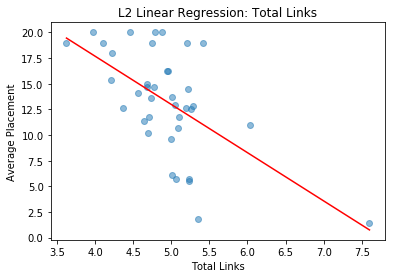

slope: -4.700932140330345
r: -0.5922252305118628
p: 8.970007390280536e-05
std_err 1.0660025711571395



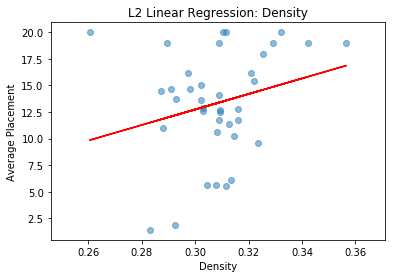

slope: 73.04211661257081
r: 0.24830250928089306
p: 0.13279740064441628
std_err 47.49221911756587



In [46]:
for i in range(2):

    X = []
    y = []

    for team in ordered_teams:
        X.append(ordered_teams[team][i])
        y.append(placements[team])

    slope, intercept, r_value, p_value, std_err = stats.linregress(X,y)
    
    yPred1 = [intercept + slope * x for x in X]
    plt.scatter(X, y,alpha=0.5)
    plt.plot(X, yPred1, 'r', label="Linear")
    plt.title("L2 Linear Regression: " + metrics[i])
    plt.ylabel("Average Placement")
    plt.xlabel(metrics[i])
    plt.show()
    
    print("slope:", slope)
    print("r:", r_value)
    print("p:", p_value)
    print("std_err", std_err)
    print()